## Gene constraint is most sensitive to CpG density and conservation of promoters (MARGINAL dependence)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [2]:
import pandas as pd 

def get_promoters(window_size, window_stride):
    CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'
    promoters_filename = (
        f'{CONSTRAINT_TOOLS_DATA}/promoters-windowSize/grch38/'
        f'promoters-with-zscores.windowSize-{window_size}.windowStride-{window_stride}.bed'
    )
    df = pd.read_csv(promoters_filename, sep='\t')
    
    # filter NaN
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    df = df[row_has_NaN == False]
    
    return df

promoters = get_promoters(1001, 40)
promoters

,transcript_id,gene_id,gene_name,cpg_density_region_grch38,loeuf,oe_lof_point_estimate,promoter_phastcons,exonic_phastcons,region_grch38,region_grch38_length,...,Chromosome,Start,End,promoter_id,number_neutral_bases,number_neutral_parts,N_bar_mean_neutral,N_observeds_mean_neutral,K_bar_mean_neutral,K_observeds_mean_neutral
0,ENST00000378156,ENSG00000131697,NPHP4,0.637959,0.984,0.77936,0.151475,0.617473,chr1:5990473-5994471,3999,...,chr1,5990473,5994471,0,2811,7,-2.210673,214.000000,0.517183,117.333333
1,ENST00000349533,ENSG00000116678,LEPR,0.562905,0.282,0.16182,0.034375,0.643277,chr1:65418653-65422651,3999,...,chr1,65418653,65422651,1,3395,5,-1.747065,187.785714,-1.129201,91.928571
2,ENST00000366577,ENSG00000116984,MTR,0.686405,0.582,0.42443,0.055250,0.859294,chr1:236793311-236797309,3999,...,chr1,236793311,236797309,2,3494,6,-1.194290,205.555556,0.499187,112.777778
4,ENST00000375847,ENSG00000116138,DNAJC16,0.664360,0.788,0.56008,0.140700,0.855939,chr1:15524814-15528812,3999,...,chr1,15524814,15528812,4,3060,5,-1.229557,209.833333,0.249845,112.833333
5,ENST00000371839,ENSG00000186094,AGBL4,0.374626,0.735,0.46218,0.097675,0.909325,chr1:50021915-50025913,3999,...,chr1,50021915,50025913,5,1791,1,-4.922763,142.210526,0.348165,79.789474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,ENST00000290429,ENSG00000100294,MCAT,0.627162,1.199,0.63850,0.091425,0.821537,chr22:43141396-43145394,3999,...,chr22,43141396,43145394,2202,3453,7,-0.611780,224.400000,1.650211,132.400000
2192,ENST00000266088,ENSG00000100170,SLC5A1,0.177320,0.746,0.49744,0.091225,0.830670,chr22:32041033-32045031,3999,...,chr22,32041033,32045031,2204,3841,3,-2.572807,172.294118,0.869387,98.823529
2194,ENST00000248958,ENSG00000128228,SDF2L1,0.565301,1.025,0.32604,0.167800,0.878299,chr22:21640262-21644260,3999,...,chr22,21640262,21644260,2206,2243,6,-4.660437,214.000000,1.054027,122.000000
2195,ENST00000215917,ENSG00000100104,SRRD,0.529636,1.492,0.90573,0.044775,0.623305,chr22:26481878-26485876,3999,...,chr22,26481878,26485876,2207,3084,3,-4.225251,152.105263,0.847838,88.210526


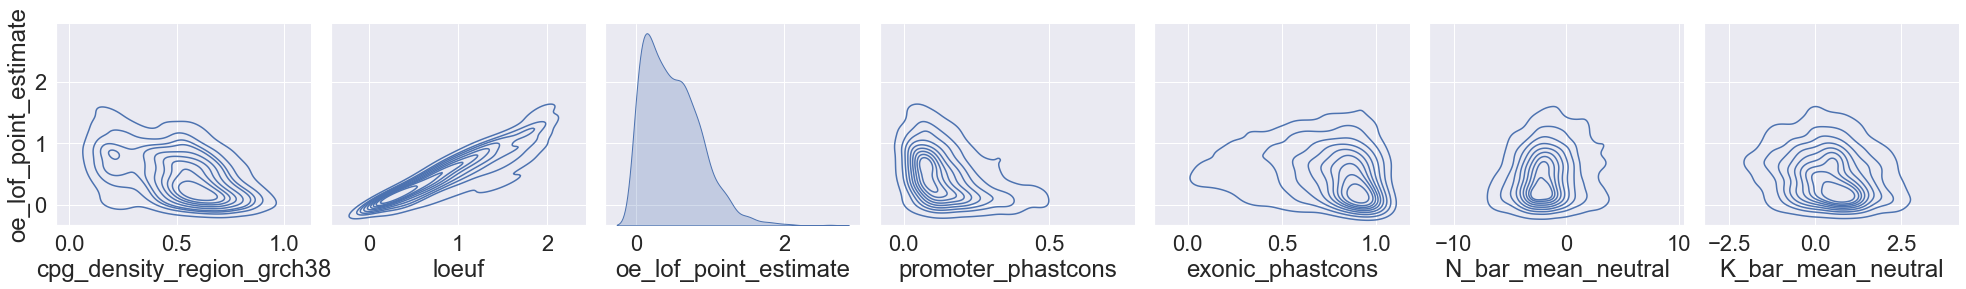

In [3]:
import seaborn as sns
sns.set(font_scale = 2)

x_vars = [
    'cpg_density_region_grch38', 
    'loeuf', 
    'oe_lof_point_estimate', 
    'promoter_phastcons', 
    'exonic_phastcons', 
    'N_bar_mean_neutral', 
    'K_bar_mean_neutral'
]

sns.pairplot(
    data=promoters,
    x_vars=x_vars,
    y_vars=['oe_lof_point_estimate'],
    kind='kde',
    height=4
)

# NOTE: sklearn provides a convenience function to correlate a target variable with its predictors: 
# https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence-plots

In [4]:
# "Following previous work,39 we classified genes with LOEUF < 0.35 as highly LoF intolerant."
# https://www.sciencedirect.com/science/article/pii/S0002929720302445?via%3Dihub
# https://ars.els-cdn.com/content/image/1-s2.0-S0002929720302445-mmc1.pdf

promoters['LoF_intolerant'] = promoters['loeuf'] < 0.35
# promoters['LoF_intolerant'] = promoters['oe_lof_point_estimate'] < 0.35

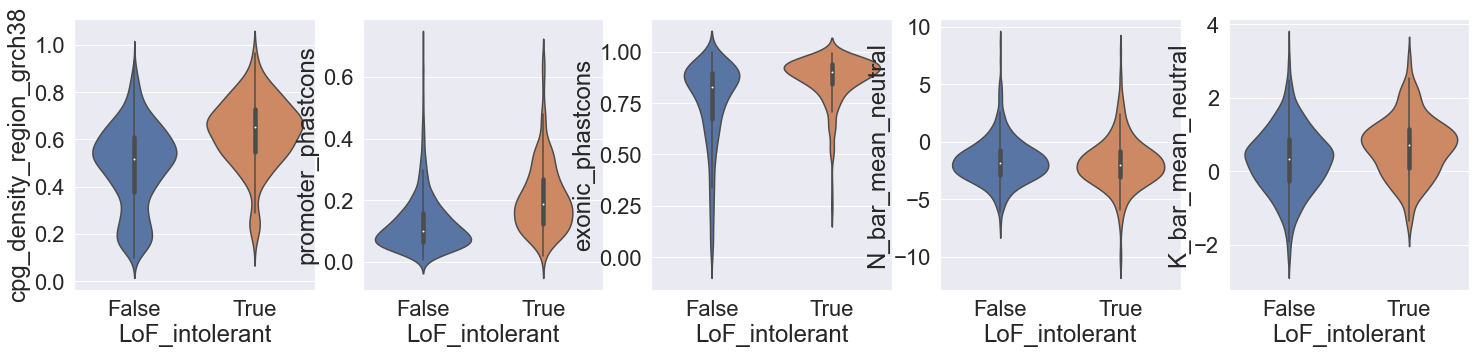

In [5]:
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1, 5, figsize=(25,5))

for i, y in enumerate(['cpg_density_region_grch38', 'promoter_phastcons', 'exonic_phastcons', 'N_bar_mean_neutral', 'K_bar_mean_neutral']):
    sns.violinplot(
        data=promoters, 
        y=y, 
        x="LoF_intolerant",
        ax=axs[i]
    )

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# logistic regression: 
# "settled on training a logistic regression model with CpG density, and promoter/exonic conservation as three linear predictors."
# https://github.com/hansenlab/lof_prediction_paper_repro/blob/ebc7d30c01def485cc0f9e62457904a4b86409ca/predLoF_CpG_training_and_assessment.R#L12

# https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://machinelearningmastery.com/cost-sensitive-logistic-regression/
pipe = make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced"))


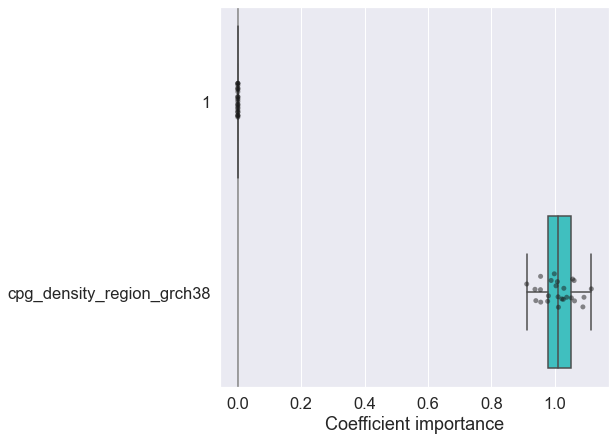

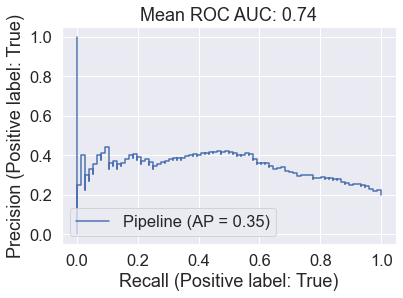

In [7]:
def compute_metrics(predictors): 
    X = promoters[predictors]

    from sklearn.preprocessing import PolynomialFeatures
#     poly = PolynomialFeatures(degree=2, interaction_only=True)
    poly = PolynomialFeatures(degree=1, interaction_only=True)
    transformed_X = poly.fit_transform(X)
    transformed_predictors = poly.get_feature_names_out(X.columns)
    X = pd.DataFrame(transformed_X, columns=transformed_predictors) 

    y = promoters['LoF_intolerant']

    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import RepeatedStratifiedKFold

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
    cv_output = cross_validate(
        pipe,
        X,
        y,
        cv=cv,
        return_estimator=True,
        n_jobs=-1, # n_jobs = -1 means using all processors
    )
    models = cv_output["estimator"]
    # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients
    # NOTE: another approach to computing feature importance is: https://scikit-learn.org/stable/modules/permutation_importance.html
    regression_coefficients = pd.DataFrame(
        [
            model.get_params()['logisticregression'].coef_.flatten() 
            for model in models
        ],
        columns=transformed_predictors,
    )

    plt.figure(figsize=(9, 7))
    sns.stripplot(data=regression_coefficients, orient="h", color="k", alpha=0.5)
    sns.boxplot(data=regression_coefficients, orient="h", color="cyan", saturation=0.5, whis=10)
    plt.axvline(x=0, color=".5")
    plt.xlabel("Coefficient importance")
    plt.subplots_adjust(left=0.3)

    from sklearn.model_selection import cross_val_score
    import numpy as np 

    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    title_line = 'Mean ROC AUC: %.2f' % np.mean(scores)

    from sklearn.metrics import PrecisionRecallDisplay
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    pipe.fit(X_train, y_train)
    precision_recall_display = PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test)
    
    ax = precision_recall_display.ax_
    ax.set_title(title_line)
    
sns.set(font_scale = 1.5)    
compute_metrics(predictors=[
    'cpg_density_region_grch38'
])

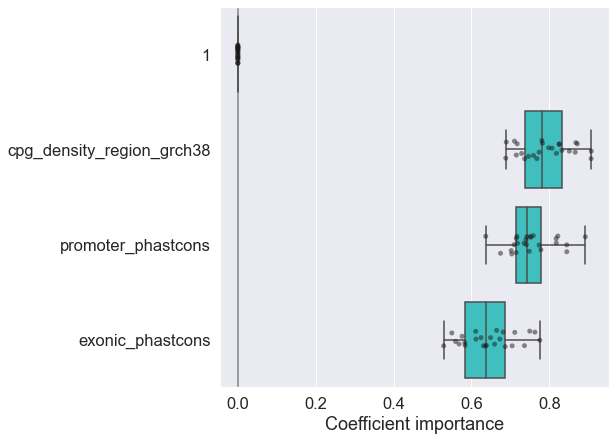

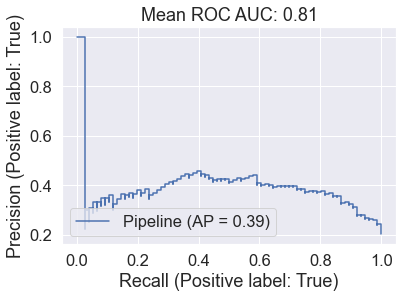

In [8]:
compute_metrics(predictors=[
    'cpg_density_region_grch38', 
    'promoter_phastcons', 
    'exonic_phastcons'
])

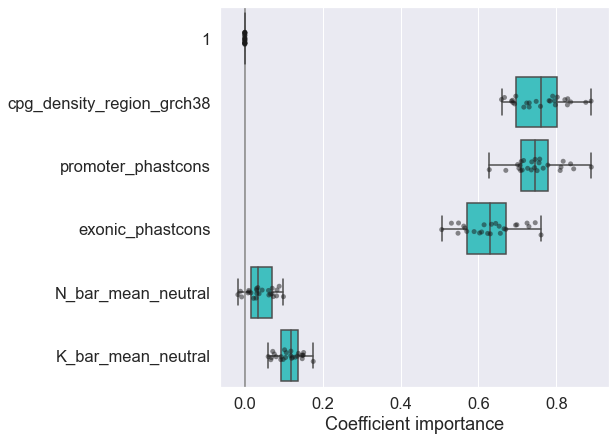

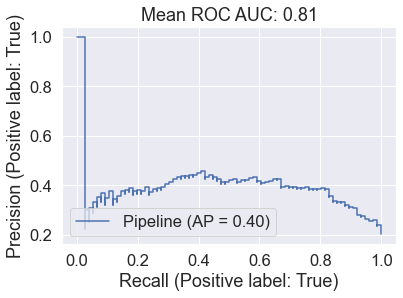

In [9]:
compute_metrics(predictors=[
    'cpg_density_region_grch38', 
    'promoter_phastcons', 
    'exonic_phastcons', 
    'N_bar_mean_neutral', 
    'K_bar_mean_neutral'
])

Note that the error bars on the regression coefficients for the two z-scores (`N_bar_mean_neutral` and `K_bar_mean_neutral`) are "small" indicating that they are not highly correlated, consistent with earlier results. 

## Singleton density within a promoter COMPLEMENTS its conservation in predicting constraint of downstream gene (CONDITIONAL dependence)

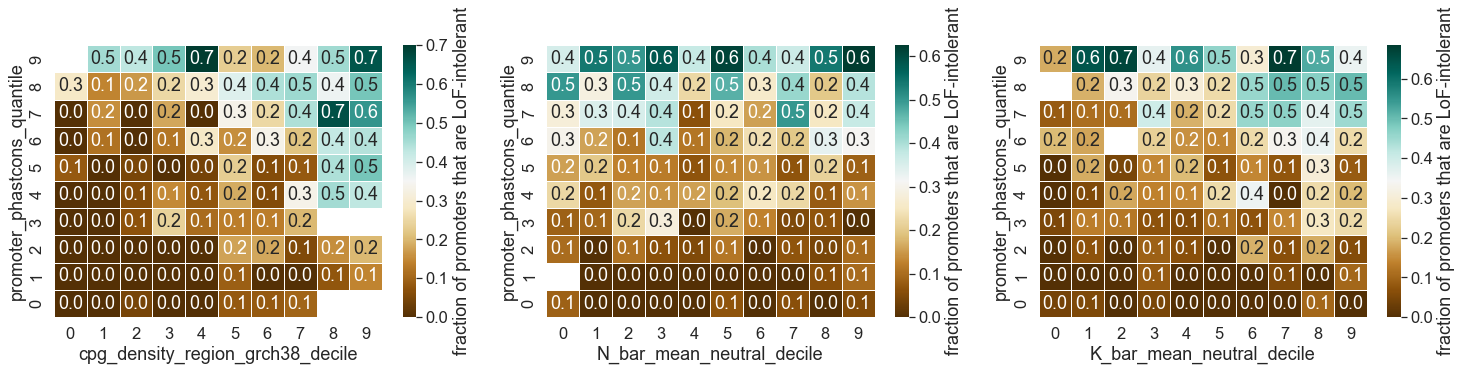

In [10]:
def plot_gene_constraint_heat_map(x, y, z, count_threshold, ax): 
    # assign records to quantile bins
    promoters[f'{x}_decile'] = pd.qcut(promoters[x], 10, labels=False)
    promoters[f'{y["column"]}_quantile'] = pd.qcut(promoters[y['column']], y['number_of_quantiles'], labels=False)

    grouped_promoters = promoters.groupby([f'{x}_decile', f'{y["column"]}_quantile'])
    
    # aggregate gene constraint scores for each promoter-based quantile bin 
    gene_scores = grouped_promoters.agg({z["column"]: ['mean']})
    gene_scores.columns = [f'{z["column"]}_mean']
    gene_scores = gene_scores.reset_index()
    
    # pivot the data into a 2d array 
    # https://pandas.pydata.org/docs/user_guide/reshaping.html#reshaping-by-pivoting-dataframe-objects
    gene_scores = gene_scores.pivot(index=f'{y["column"]}_quantile', columns=f'{x}_decile', values=f'{z["column"]}_mean')

    promoter_counts = pd.DataFrame(grouped_promoters.size())
    promoter_counts.columns = ['counts']
    promoter_counts = promoter_counts.reset_index()

    promoter_counts = promoter_counts.pivot(index=f'{y["column"]}_quantile', columns=f'{x}_decile', values='counts')

    mask = promoter_counts < count_threshold

    # plot a heat map
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    sns.heatmap(
        gene_scores, 
        cmap = 'BrBG', 
        center = 0.5*(gene_scores.max().max() + gene_scores.min().min()), 
        annot = True, 
        fmt = '.1f', 
        linewidths = .5, 
        cbar_kws = {'label': z['label']},
        ax = ax,
        mask = mask
    )
    ax.invert_yaxis()
    
#     sns.pairplot(
#         data=promoters,
#         x_vars=['K_bar_mean_neutral'],
#         y_vars=['oe_lof_point_estimate'],
#         kind='scatter',
#         height=10,
#         hue=f'{y["column"]}_quantile',
#         palette = 'BrBG',
#     )
    
    
def plot_gene_constraint_heat_maps(z):
    # sns.set(rc = {'figure.figsize': (10, 8)})
    sns.set(font_scale = 1.5)

    with sns.axes_style("white"):        
        fig, axs = plt.subplots(1, 3, figsize=(25,5))
        for i, x in enumerate(['cpg_density_region_grch38', 'N_bar_mean_neutral', 'K_bar_mean_neutral']):
            plot_gene_constraint_heat_map(
                x = x,
                y = { 
                    'column': 'promoter_phastcons',
                    'number_of_quantiles': 10
                },
                z = z,
                count_threshold = 7,
                ax = axs[i]
            )


        
plot_gene_constraint_heat_maps(
    z = {
        'column': 'LoF_intolerant',
        'label': 'fraction of promoters that are LoF-intolerant'
    },
)

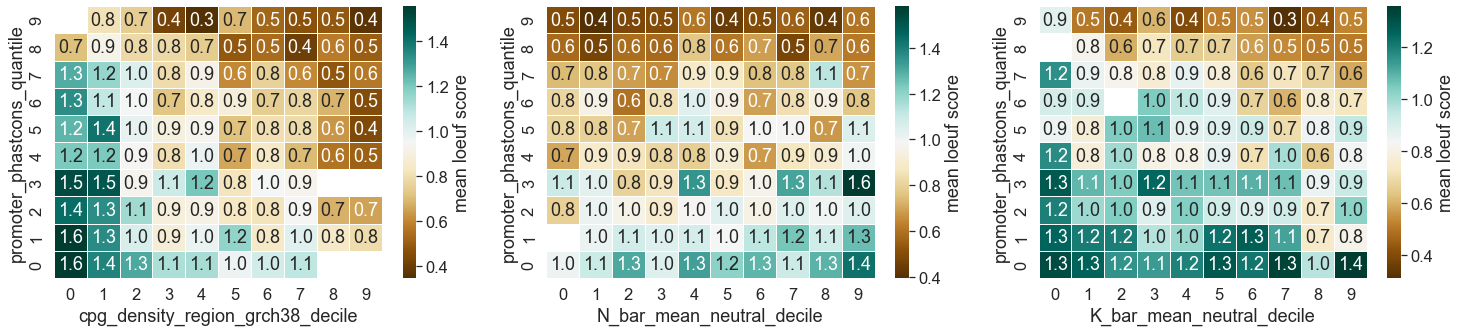

In [11]:
plot_gene_constraint_heat_maps(
    z = {
        'column': 'loeuf',
        'label': 'mean loeuf score'
    },
)

## Conclusion

While promoter SNV and singleton density have a weak marginal effect on gene constraint (allowing CpG density and conservation of the promoter to vary), they do have a significant conditional effect (fixing the CpG density and conservation of promoter). 

This phenomenon of the dependence of a target variable on a predictor variable being masked by other predictor variables
has been described before: 
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html


## Addendum: Spot checking loci in various cells of heat map

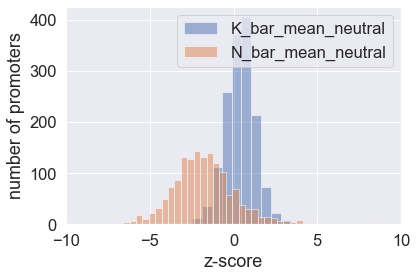

In [12]:
def plot_zscore_distribution(promoters_):
    ax = promoters_['K_bar_mean_neutral'].hist(alpha=0.5, label='K_bar_mean_neutral', bins=10)
    ax.set_xlabel('z-score')
    ax.set_ylabel('number of promoters')
    promoters_['N_bar_mean_neutral'].hist(ax=ax, alpha=0.5, label='N_bar_mean_neutral', bins=50)
    ax.legend()
    ax.set_xlim([-10, 10])
    
plot_zscore_distribution(promoters)


transcript_id                            ENST00000378404
gene_id                                  ENSG00000169717
gene_name                                         ACTRT2
cpg_density_region_grch38                       0.365197
loeuf                                              1.421
oe_lof_point_estimate                            0.72558
promoter_phastcons                              0.194375
exonic_phastcons                                0.644004
region_grch38                       chr1:3019483-3023481
region_grch38_length                                3999
region_grch38_clipped               chr1:3020983-3021981
Chromosome                                          chr1
Start                                            3019483
End                                              3023481
promoter_id                                          201
number_neutral_bases                                2561
number_neutral_parts                                   3
N_bar_mean_neutral             

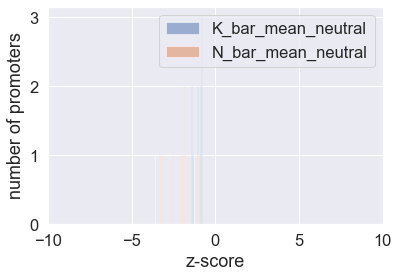

In [13]:
def subset_promoters(K_bar_mean_neutral_decile): 
    promoters_subset = promoters[
        (promoters['promoter_phastcons_quantile'] == 7) &
        (promoters['K_bar_mean_neutral_decile'] == K_bar_mean_neutral_decile)
    ]
    plot_zscore_distribution(promoters_subset)
    print(promoters_subset.iloc[0])

subset_promoters(K_bar_mean_neutral_decile=0)

transcript_id                                ENST00000361738
gene_id                                      ENSG00000143409
gene_name                                             FAM63A
cpg_density_region_grch38                           0.448114
loeuf                                                  1.287
oe_lof_point_estimate                                0.92138
promoter_phastcons                                   0.18165
exonic_phastcons                                     0.79476
region_grch38                       chr1:151006377-151010375
region_grch38_length                                    3999
region_grch38_clipped               chr1:151007877-151008875
Chromosome                                              chr1
Start                                              151006377
End                                                151010375
promoter_id                                              129
number_neutral_bases                                    3044
number_neutral_parts    

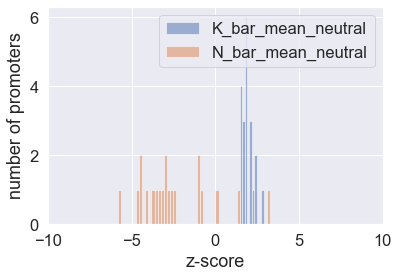

In [14]:
subset_promoters(K_bar_mean_neutral_decile=9)

In [15]:
# promoters.sort_values(by=['K_bar_mean_neutral'], ascending=False).iloc[0]